In [1]:
import sys
import numpy as np
import cv2
from IPython.display import Image, display
from ipywidgets import widgets
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.figure import Figure as Figure
from matplotlib.axes import Axes as Axes
import logging
logging.basicConfig(level=logging.INFO)

print("python version:", sys.version)
print("numpy version:", np.__version__)
print("opencv version:", cv2.__version__) # type: ignore

python version: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
numpy version: 1.25.0
opencv version: 4.8.0


In [3]:
def drawInSubplot(fig:Figure, pos, img, title="", colorbar=False):
    ax = fig.add_subplot(*pos)
    axImage = ax.imshow(img)
    if title:
        ax.set_title(title)
    if colorbar:
        fig.colorbar(axImage, ax=ax)
    return ax,axImage


def plotInSubplot(fig:Figure, pos, data, title="", legend=True):
    ax = fig.add_subplot(*pos)
    if type(data) == dict:
        for k,v in data.items():
            ax.plot(v[0],v[1], label=k)
        ax.legend()
    elif type(data)==tuple:
        if (type(data[0])==tuple):
            for d in data:
                ax.plot(d[0],d[1])
        else:
            ax.plot(data[0],data[1])
    if title:
        ax.set_title(title)
    return ax

(512, 512) uint16
(2560, 2560) uint8
(981, 983, 3) uint8


(<Axes: title={'center': 'manually marked'}>,
 <matplotlib.image.AxesImage at 0x7f47fef203d0>)

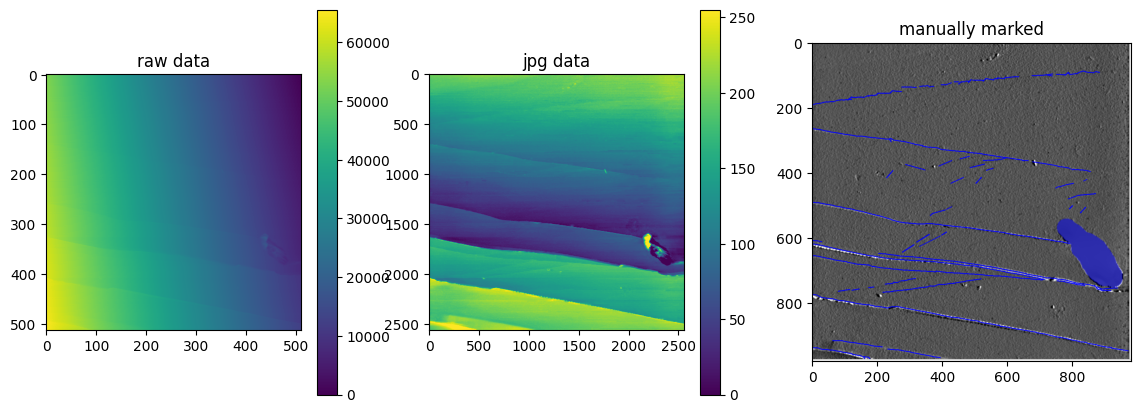

In [4]:
raw_data = cv2.imread("data/data1/rawdata1.tif",cv2.IMREAD_UNCHANGED)
print(raw_data.shape, raw_data.dtype)
jpg_data = cv2.cvtColor(cv2.imread("data/data1/rawdata1.jpg"), cv2.COLOR_BGR2GRAY)
print(jpg_data.shape, jpg_data.dtype)
manually_marked = cv2.imread("data/data1/rawdata1_manually_marked.png")
print(manually_marked.shape, manually_marked.dtype)

UINT16TO8 = "uint16_to_uint8"
F32TOUINT8 = "float32_to_uint8"
F32TOUINT16 = "float32_to_uint16"
def compress(img:np.ndarray,mode=UINT16TO8)->np.ndarray:
    if mode == UINT16TO8:
        return (img.astype(np.float32)/256).astype(np.uint8)
    elif mode == F32TOUINT8:
        leveled = (img - img.min())/(img.max()-img.min())
        return (leveled*255).astype(np.uint8)
    elif mode == F32TOUINT16:
        leveled = (img - img.min())/(img.max()-img.min())
        return (leveled*65535).astype(np.uint16)
    else:
        raise ValueError("Unknown compression mode.")

fig = plt.figure(figsize=(14,5))
drawInSubplot(fig, (1,3,1), raw_data, "raw data", colorbar=True)
drawInSubplot(fig, (1,3,2), jpg_data, "jpg data", colorbar=True)
drawInSubplot(fig, (1,3,3), manually_marked, "manually marked")

<Axes: title={'center': 'line profiles'}>

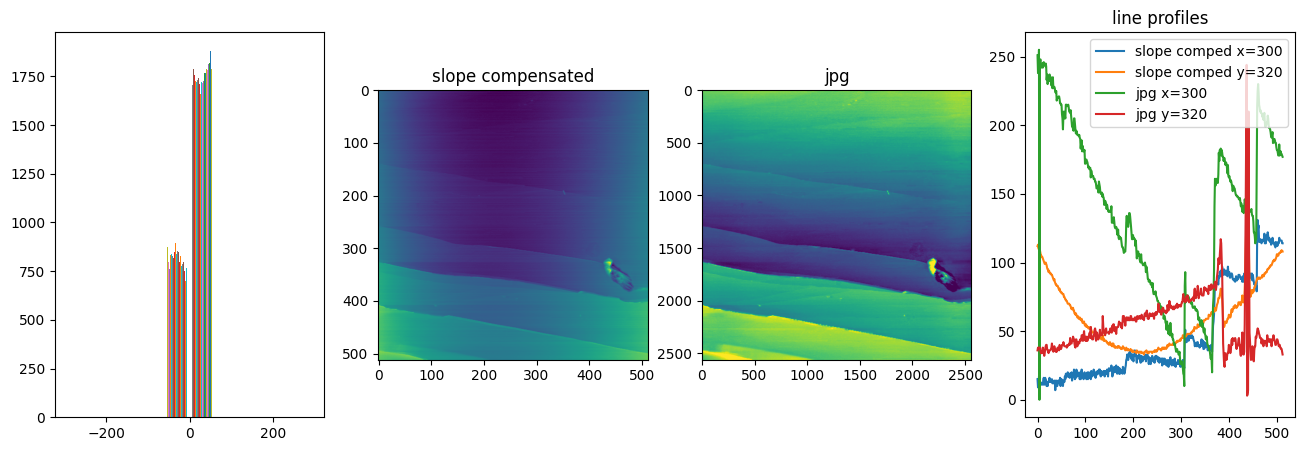

In [8]:
raw_data = cv2.imread("data/data1/rawdata1.tif",cv2.IMREAD_UNCHANGED)
jpg_data = cv2.cvtColor(cv2.imread("data/data1/rawdata1.jpg"), cv2.COLOR_BGR2GRAY)

def slopeComp(img:np.ndarray, slope:float, axis:int)->np.ndarray:
    out_dtype = img.dtype
    x = np.arange(img.shape[axis]).astype(np.float32)
    y = x*slope
    if axis == 0:
        base = y.reshape((1,-1)).repeat(img.shape[1], axis=0)
    elif axis == 1:
        base = y.reshape((-1,1)).repeat(img.shape[0], axis=1)
    else:
        raise ValueError("invalid axis")
    f_array = img.astype(np.float32) - base
    maxval = f_array.max()
    minval = f_array.min()
    rangeval = maxval - minval
    if out_dtype == np.uint8:
        if rangeval > 256:
            logging.warning("rangeval > 256")
        if maxval >= 256:
            f_array -= maxval - 255
        elif minval < 0:
            f_array -= minval
        return f_array.astype(np.uint8)
    elif out_dtype == np.uint16:
        if rangeval > 65536:
            logging.warning("rangeval > 65536")
        if maxval >= 65536:
            f_array -= maxval - 65535
        elif minval < 0:
            f_array -= minval
        return f_array.astype(np.uint16)
    else:
        return f_array

dx = cv2.filter2D(raw_data.astype(np.float32),-1,np.array([[-1.0,1.0]]))
dy = cv2.filter2D(raw_data.astype(np.float32),-1,np.array([[-1.0],[1.0]]))
mdx = np.median(dx)
mdy = np.median(dy)
slope_comped = compress(slopeComp(slopeComp(raw_data, mdx, 0), mdy, 1), F32TOUINT8)

dy = cv2.filter2D(jpg_data.astype(np.float32),-1,np.array([[-1.0],[1.0]]))
mdx = np.median(cv2.filter2D(jpg_data.astype(np.float32),-1,np.array([[-1.0,1.0]])))
mdy = np.median(dy)
jpg_flatten = compress(slopeComp(slopeComp(jpg_data, mdx, 0), 0.023, 1), F32TOUINT8)

fig = plt.figure(figsize=(16,5))
# drawInSubplot(fig, (1,4,1), raw_data, "raw data")

ax1 = fig.add_subplot(1,4,1)
ax1.hist(dy, bins=np.arange(-300, 301, 60))
drawInSubplot(fig, (1,4,2), slope_comped, "slope compensated")

drawInSubplot(fig, (1,4,3), jpg_data, "jpg")

idx = np.arange(512)
plotInSubplot(fig, (1,4,4),{
        "slope comped x=300":(idx,slope_comped[:,300]),
        "slope comped y=320":(idx,slope_comped[320,:]),
        "jpg x=300":(idx,jpg_flatten[::5,1500]),
        "jpg y=320":(idx,jpg_flatten[1600,::5])
    }, "line profiles", legend=True
)

mind :dtype= float32 max= 70.22222 min= 0.0
grad :dtype= float32 max= 149.73665 min= 4.0122604e-08


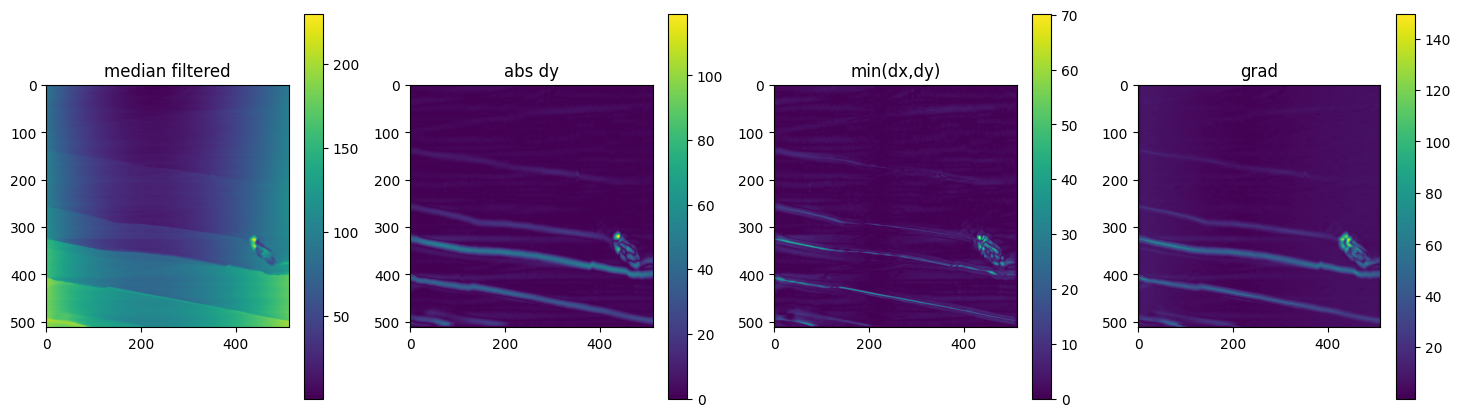

In [7]:
def longPrewitt(img:np.ndarray, size:tuple[int,int], axis:int)->np.ndarray:
    if (axis < 0 or axis > 1):
        raise ValueError("invalid axis")
    halfwidth = size[1-axis] // 2
    kernel = np.hstack((-np.ones(halfwidth),np.zeros(size[not axis]%2),np.ones(halfwidth))) / halfwidth
    shape = (1-axis*2, axis*2-1) # 0->(1,-1), 1->(-1,1)
    kernel = np.repeat(kernel.reshape(shape), size[axis], axis=1-axis) / size[axis]
    return cv2.filter2D(img.astype(np.float32),-1,kernel)

med_size = 5
prewitt_size = 7
prewitt_width = 3

med = cv2.medianBlur(slope_comped,med_size)
dx = longPrewitt(med, (prewitt_width,prewitt_size), 0)
dy = longPrewitt(med, (prewitt_size,prewitt_width), 1)
grad = np.sqrt(dx**2 + dy**2)
mind = dx.copy()
mind[np.abs(dy)<np.abs(dx)] = dy[np.abs(dy)<np.abs(dx)]
mind = np.abs(mind)

fig = plt.figure(figsize=(18,5))
drawInSubplot(fig, (1,4,1), med, "median filtered", colorbar=True)
drawInSubplot(fig, (1,4,2), np.abs(dy), "abs dy", colorbar=True)
drawInSubplot(fig, (1,4,3), mind, "min(dx,dy)", colorbar=True)
drawInSubplot(fig, (1,4,4), grad, "grad", colorbar=True)
print("mind :dtype=",mind.dtype, "max=",mind.max(), "min=",mind.min())
print("grad :dtype=",grad.dtype, "max=",grad.max(), "min=",grad.min())


iter count =  1


(<Axes: title={'center': 'grad binarized'}>,
 <matplotlib.image.AxesImage at 0x7fad7cd852a0>)

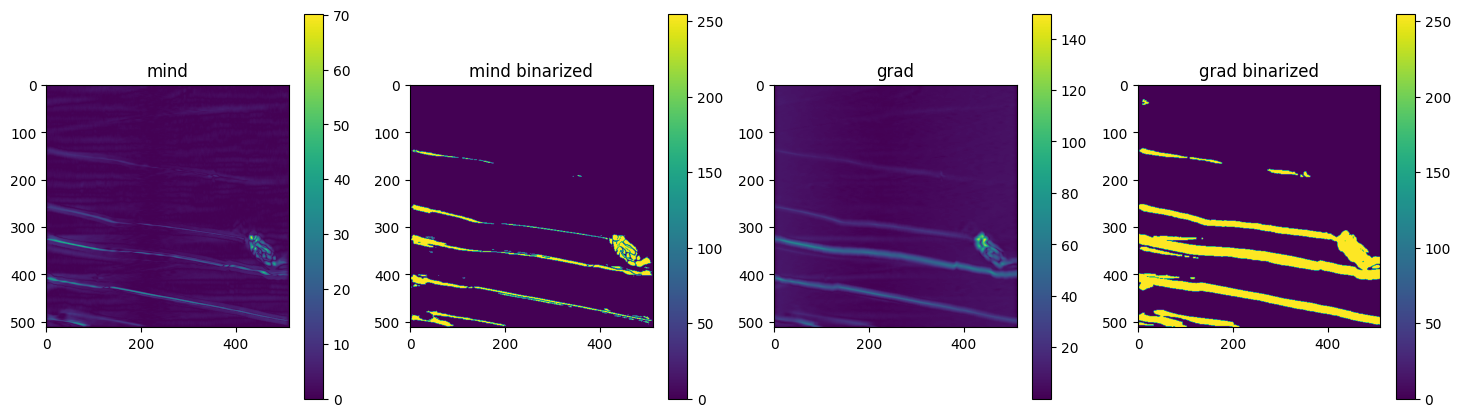

In [11]:
def binarize(img, upper_thresh, lower_thresh=None, *, iter=1)->np.ndarray:
    I = np.ones_like(img, dtype=np.uint8)
    edge = img >= upper_thresh
    if lower_thresh is None:
        return edge.astype(np.uint8) * 255
    
    edge = edge.astype(np.uint8)
    possible = (img >= lower_thresh).astype(np.uint8)
    k = np.ones((3,3), dtype=np.uint8)
    s = 0
    count = 0
    while (s != edge.sum()) and (count < iter):
        count += 1
        edge = cv2.dilate(edge, k) * possible
        s = edge.sum()
    print("iter count = ", count)
    return edge * 255

mind_binarized = binarize(mind, 7, iter=100)
grad_binarized = binarize(grad, 10,5,iter=100)

fig = plt.figure(figsize=(18,5))
drawInSubplot(fig, (1,4,1), mind, "mind", colorbar=True)
drawInSubplot(fig, (1,4,2), mind_binarized, "mind binarized", colorbar=True)
drawInSubplot(fig, (1,4,3), grad, "grad", colorbar=True)
drawInSubplot(fig, (1,4,4), grad_binarized, "grad binarized", colorbar=True)

In [ ]:

def drawInSubplot(fig, pos, img, title="", colorbar=False):
    ax = fig.add_subplot(*pos)
    axImage = ax.imshow(img)
    if title:
        ax.set_title(title)
    if colorbar:
        fig.colorbar(ax.imshow(img), ax=ax)
    return ax,axImage


In [ ]:
raw_data1 = cv2.cvtColor(cv2.imread("data/data1/rawdata1.jpg"), cv2.COLOR_BGR2GRAY)
print(raw_data1.shape, raw_data1.dtype)
manually_marked = cv2.imread("data/data1/rawdata1_manually_marked.png")
print(manually_marked.shape, manually_marked.dtype)

data = cv2.GaussianBlur(raw_data1, (1,11), 11)
data = slopeComp(data, -46/500, 0, 0.5)
m_size, s_size = 41, 11
med = cv2.medianBlur(data, m_size)

dy = broadD(data, m_size, s_size, axis=1)
binarized = binarize(dy, 20)

linedetect = cv2.HoughLinesP(binarized, 1, np.pi/180, 100, 0, 0)

fig = plt.figure(figsize=(24, 16))
drawInSubplot(fig, (2, 4, 1), manually_marked, "manually_marked")
drawInSubplot(fig, (2, 4, 2), raw_data1, "raw")
drawInSubplot(fig, (2, 4, 5), data, "gaussian&slope_comp&med")
drawInSubplot(fig, (2, 4, 6), med, "med")
drawInSubplot(fig, (1, 2, 2), dy, "dy", True)
# drawInSubplot(fig, (2, 4, 6), binarized, "binarized")

# ax7 = fig.add_subplot(2, 2, 4)
# ax7.plot(raw_data1[:,1000], label="raw")
# ax7.plot(data[:,1000], label="slope_comp")
# ax7.plot(med[:,1000], label="med", color=(0, 1, 0, 0.5))
# ax7.plot(dy[:,1000], label="dy", color=(0, 0, 1, 0.5))
# ax7.plot(binarized[:,1000], label="binarized", color=(1, 0, 0, 0.5))
# ax7.legend()

fig.show()

In [ ]:
slider_width = "600px"
# bin_thresh
bin_thresh_slider = widgets.IntSlider(min=1, max=255, step=1, value=1, description="bin_thresh: ")
bin_thresh_slider.layout.width = slider_width
# rho
rho_slider = widgets.IntSlider(min=1, max=10, step=1, value=1, description="rho: ")
rho_slider.layout.width = slider_width
# theta
theta_slider = widgets.IntSlider(min=1, max=180, step=1, value=1, description="theta: ")
theta_slider.layout.width = slider_width
# vote_thresh
vote_thresh_slider = widgets.IntSlider(
    min=0, max=500, step=1, value=100, description="threshold: "
)
vote_thresh_slider.layout.width = slider_width
# min_len
min_len_slider = widgets.IntSlider(
    min=0, max=500, step=1, value=0, description="minLineLength: "
)
min_len_slider.layout.width = slider_width
# max_gap
max_gap_slider = widgets.IntSlider(
    min=0, max=500, step=1, value=50, description="maxLineGap: "
)
max_gap_slider.layout.width = slider_width

# 画像を読み込む。
img = cv2.resize(dy, (640,640))
raw = cv2.resize(raw_data1, (640,640))

# ウィジェットを表示する。
widgets.interactive(
    detectStep,
    raw = widgets.fixed(raw),
    gray=widgets.fixed(img),
    bin_thresh=bin_thresh_slider,
    rho=rho_slider,
    theta=theta_slider,
    vote_thresh=vote_thresh_slider,
    min_len=min_len_slider,
    max_gap=max_gap_slider,
)